## Gender Stats

Since the GenderAPI data seems a bit more comprehensive ([see here](./gender_methods.ipynb)), that's what we'll use going forward. This first block recapitulates what I did in the beginning of the last notebook.function bs2{T<:Number}(a::DataArray{T}, n::Int)
    means = @data(Float64[])
    for x in 1:n
        push!(means, mean(dropna(
            sample!(a, similar(a, length(a)))
            )))
    end
    means = dropna(means)
    return (mean(means), [quantile(means, .025), quantile(means, .975)])
end

In [1]:
using StatPlots


include("../src/dataimport.jl") # `importauthors()` and `getgenderprob()` functions

bio = importauthors("../data/pubdata/bio.csv", "bio")
comp = importauthors("../data/pubdata/comp.csv", "comp")
alldata = vcat(bio, comp)
bio = 0 # to free up memory
comp = 0

alldata[:Pfemale], alldata[:Count] = getgenderprob(alldata, "../data/genders/genderAPI_genders.json", :Author_First_Name)

pool!(alldata)
alldata = alldata[!isna(alldata[:Journal]), :] # remove rows where there's no Journal

alldata[1:5, 1:7]


,ID,Date,Journal,Author_First_Name,Author_Last_Name,Author_Initials,Position
1,26466425,2015-10-15,Southeast Asian J. Trop. Med. Public Health,Suwit,Chotinun,NA,first
2,26466425,2015-10-15,Southeast Asian J. Trop. Med. Public Health,Prapas,Patchanee,NA,last
3,26466425,2015-10-15,Southeast Asian J. Trop. Med. Public Health,Suvichai,Rojanasthien,NA,second
4,26466425,2015-10-15,Southeast Asian J. Trop. Med. Public Health,Pakpoom,Tadee,NA,penultimate
5,26466425,2015-10-15,Southeast Asian J. Trop. Med. Public Health,Fred,Unger,NA,other


In [2]:
means = by(alldata, [:Dataset], df -> DataFrame(MeanPF = mean(dropna(df[:Pfemale]))))

,Dataset,MeanPF
1,bio,0.34048754243415824
2,comp,0.29633429724211385



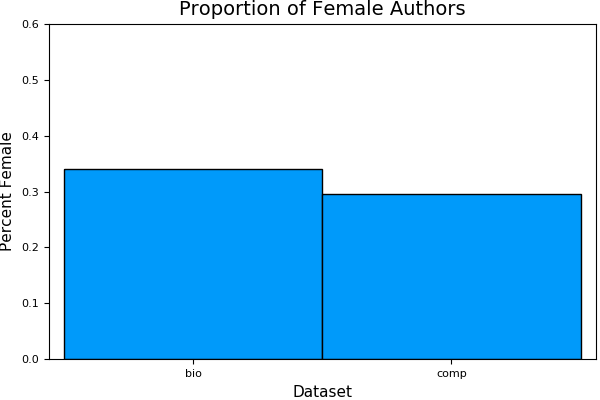

sys:1: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


In [3]:
bar(means, :MeanPF,
        xaxis=("Dataset", ([1,2], means[:Dataset])),
        yaxis=("Percent Female", (0, 0.6), 0:0.1:0.6),
        legend=false,
        grid=false,
        title="Proportion of Female Authors")

Currently, the author positions are ordered in the dataframe in alphabetical order (first, last, other, penultimate, second), so I'm going to define a "less than" function to do a custom sort (thanks [Stack Overflow](http://stackoverflow.com/questions/37932963/efficient-custom-ordering-in-julia-dataframes)!). This function needs to return true for the call `x < y` for the strings in the following order: ["first", "second", "other", "penultimate", "last"]. 

In [4]:
order = Dict(key => ix for (ix, key) in enumerate(["first", "second", "other", "penultimate", "last"]))


function authororder(pos1, pos2)
    return order[pos1] < order[pos2]
end

println(authororder("first", "second"))
println(authororder("second", "first"))

true
false


So now we can sort the dataframe using our custom function and the `lt` keyword.

In [5]:
sort!(alldata, cols=:Position, lt=authororder)
alldata[1:5, 1:7]

,ID,Date,Journal,Author_First_Name,Author_Last_Name,Author_Initials,Position
1,26466425,2015-10-15,Southeast Asian J. Trop. Med. Public Health,Suwit,Chotinun,NA,first
2,26466421,2015-10-15,Southeast Asian J. Trop. Med. Public Health,Chariya,Chomvarin,NA,first
3,26466418,2015-10-15,Southeast Asian J. Trop. Med. Public Health,Meng-Bin,Tang,NA,first
4,26460400,2015-10-11,Ann. Hum. Genet.,Christopher,Steele,D,first
5,26255944,2015-08-10,Mutat. Res.,Sara,Skiöld,NA,first



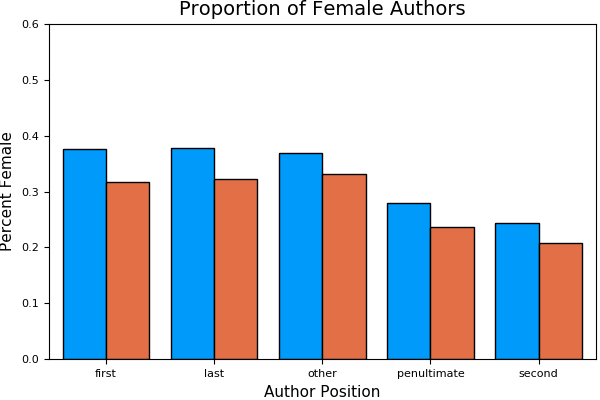

In [6]:
byposition = by(alldata, [:Position, :Dataset], df -> mean(dropna(df[:Pfemale])))
sort!(byposition, cols=:Position, lt=authororder)
ys = hcat([byposition[byposition[:Dataset] .== x, :x1] for x in levels(byposition[:Dataset])]...)

groupedbar(ys, bar_position=:dodge,
        xaxis=("Author Position", (1:5, levels(alldata[:Position]))),
        yaxis=("Percent Female", (0, 0.6), 0:0.1:0.6),
        legend=false,
        grid=false,
        title="Proportion of Female Authors")

To reiterate, these data suggest:

- Women are less likely to be authors than men
- Women are less likely to be first authors than second authors
- Women are less likely to be last authors than first authors
- this recapitulates previously published data that women are under-represented in biology publishing.

New finding: It seems to be worse in computational biology than in all of biology, though not by as much as I expected.

## Additional Annalysis

Let's see how this holds up. We can't do the "normal" sorts of statistics that folks often do (like T-tests, chi squared etc), since we're not taking a random sample of a population, we're looking at the whole population. An alternative is to use [bootstrap analysis](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)), where we randomly resample the data a bunch of times, and get statistics on those samples. Julia has a [bootstrap package](https://github.com/juliangehring/Bootstrap.jl), but it seems to be actively in development and stuff is a bit broken right now, so I decided to roll my own (my needs are modest).

The function below takes a DataArray `a` (like a column in a DataFrame), and then takes `|a|` samples with replacement. It does this `n` times, and then takes the mean, and generates a 95% confidence interval (because of the [central limit theroem](https://en.wikipedia.org/wiki/Central_limit_theorem), I can assume these samples are normally distributed).  

In [7]:
function bootstrap{T<:Number}(a::DataArray{T}, n::Int)
    means = Float64[]
    for x in 1:n
        push!(means, mean(dropna(
            sample!(a, similar(a, length(a)))
            )))
    end
    means = dropna(means) 
    return (mean(means), [quantile(means, .025), quantile(means, .975)])
end

bootstrap (generic function with 1 method)


This function takes a vector of values `v` (like, say, a group of gender probabilities), and then samples them with replacement `n` times. In other words, if I had a vector `t = [1, 2, 3, 4, 5]` and I called getbootstrap(t), it would go through and take 5 samples at random... sometimes it would be `[5, 2, 4, 3, 3]`, sometimes `[1, 1, 1, 1, 1]` etc. It would do this 1000 times, getting the mean each time.

In [8]:
t = @data([1,2,3,4,5])
(m, ci) = bootstrap(t, 1000)

(2.9941999999999993,[1.8,4.4])

The estimate for the mean is ~3, just as it should be, but I also get a confidence interval. That means that 95% of the time, the mean was between 1.6 and 4.2.

I can use this to look at the author genders:

In [9]:
by(alldata, [:Dataset, :Position]) do df
    (m, ci) = bootstrap(df[:Pfemale], 1000)
    return DataFrame(Mean=m, Lower=ci[1], Upper=ci[2])
end

,Dataset,Position,Mean,Lower,Upper
1,bio,first,0.37554899967549205,0.37341618040791885,0.37760934519023026
2,bio,last,0.2445807802726165,0.2425217412944195,0.24667229687530196
3,bio,other,0.36811105488635143,0.36672005662522206,0.36955886435787955
4,bio,penultimate,0.2794508567134617,0.2769456272599794,0.28192603507064085
5,bio,second,0.37867720975402264,0.376309021032719,0.38124814138903007
6,comp,first,0.31628457043398167,0.31216277156822253,0.32071948984831855
7,comp,last,0.20728100188266085,0.2035118072511263,0.21131039035313787
8,comp,other,0.33066245511496395,0.3278958261091234,0.3334795748392778
9,comp,penultimate,0.23616028172389428,0.2314216315959131,0.24072637668427668
10,comp,second,0.3219207849916515,0.3173954530484164,0.3265934968596715


That code takes the data, subsets it by `:Dataset` and `:Position` (that's the first two columns) and then returns the mean and 95% confidence intervals for each subset.

### Based on Journal Specialty

Another way to do this is to split by journals that tend to publish computational biology articles vs those that are more generalist. Here we'll only use the articles in the "bio" dataset to avoid double-dipping (the "comp" dataset is almost entirely a subset of "bio")

In [10]:
bioids = Set(levels(alldata[alldata[:Dataset] .== "bio", :ID]))
compids = Set(levels(alldata[alldata[:Dataset] .== "comp", :ID]))

println("There are $(length(bioids)) articles in the \"bio\" dataset")
println("There are $(length(compids)) articles in the \"comp\" dataset")

dif = length(setdiff(compids, bioids))

println("There are $dif articles in the \"comp\" dataset that aren't in the \"bio\" dataset")

There are 202816 articles in the "bio" dataset
There are 42880 articles in the "comp" dataset
There are 236 articles in the "comp" dataset that aren't in the "bio" dataset


10×5 DataFrames.DataFrame
│ Row │ Journal              │ Position      │ Mean     │ Lower    │ Upper    │
├─────┼──────────────────────┼───────────────┼──────────┼──────────┼──────────┤
│ 1   │ "PLoS Biol."         │ "first"       │ 0.332263 │ 0.279012 │ 0.389686 │
│ 2   │ "PLoS Comput. Biol." │ "first"       │ 0.243255 │ 0.224564 │ 0.261672 │
│ 3   │ "PLoS Biol."         │ "second"      │ 0.329098 │ 0.264278 │ 0.393998 │
│ 4   │ "PLoS Comput. Biol." │ "second"      │ 0.24995  │ 0.228304 │ 0.271633 │
│ 5   │ "PLoS Biol."         │ "other"       │ 0.327756 │ 0.305247 │ 0.351926 │
│ 6   │ "PLoS Comput. Biol." │ "other"       │ 0.292379 │ 0.27278  │ 0.312326 │
│ 7   │ "PLoS Biol."         │ "penultimate" │ 0.217716 │ 0.153413 │ 0.284721 │
│ 8   │ "PLoS Comput. Biol." │ "penultimate" │ 0.200221 │ 0.176161 │ 0.224715 │
│ 9   │ "PLoS Biol."         │ "last"        │ 0.24128  │ 0.190627 │ 0.303766 │
│ 10  │ "PLoS Comput. Biol." │ "last"        │ 0.1768   │ 0.16034  │ 0.194609 │


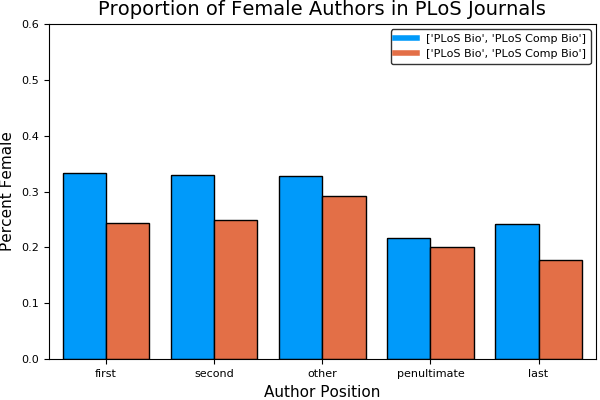

In [11]:
plosfocus = alldata[(alldata[:Dataset] .== "bio")&
    ((alldata[:Journal] .== String("PLoS Biol."))|
    (alldata[:Journal] .== String("PLoS Comput. Biol."))), :]

df = by(plosfocus, [:Journal, :Position]) do df
    (m, ci) = bootstrap(df[:Pfemale], 1000)
    return DataFrame(Mean=m, Lower=ci[1], Upper=ci[2])
end

sort!(df, cols=:Position, lt=authororder)
show(df)
ys = hcat([df[df[:Journal] .== x, :Mean] for x in ["PLoS Biol.", "PLoS Comput. Biol."]]...)

groupedbar(ys, bar_position=:dodge, lab=["PLoS Bio", "PLoS Comp Bio"],
        xaxis=("Author Position", (1:5, ["first", "second", "other", "penultimate", "last"])),
        yaxis=("Percent Female", (0, 0.6), 0:0.1:0.6),
        grid=false,
        title="Proportion of Female Authors in PLoS Journals")

Alternatively, we can look at all the journals, and look at where each journal in terms of the proportion of female authors. Here, I'm plotting out all of the journals with more than 1000 authors (each author is a line, so I can just get the number of rows with a particular journal), and coloring them grey if they have "comput", "omic", "informatic", or "system" in their title.


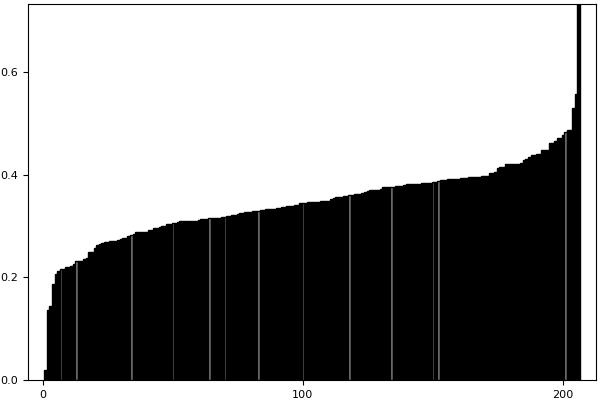

In [27]:
bio = alldata[alldata[:Dataset] .== "bio", :]
c = countmap(bio[:Journal])

journals = bio[map(x -> c[x] > 1000, bio[:Journal]), :]

function checktitle(t::String)
    for f in ["comput", "omic", "informatic", "system"]
        if contains(t, f)
            return true
        end
    end
    return false
end

data = by(journals, :Journal) do df
    m = mean(dropna(df[:Pfemale]))
    return DataFrame(Mean=m)
end

data[:Color] = [checktitle(x) ? :grey : :black for x in data[:Journal]]
data = data[!isna(data[:Mean]), :]
sort!(data, cols=:Mean)
bar(data[:Mean], color=data[:Color], grid=false, legend=false, bar_edges=false)

### Subsetting Conclusions

With a few exceptions, each of these subsets show a similar trend: women are less likely to be authors in computational biology publications. 

## Data from the arXiv

Previous work suggests that women are far less likely to publish in computer science. Unfortunately, pubmed doesn't index computer science research. 

The arXiv has preprints in many fields, including computer science. The sorts of papers posted here are likely to be different, so we can't compare directly to the stuff on pubmed, but there's also quantatative biology...

In [29]:

arxivcs = importauthors("../data/pubdata/arxivcs.csv", "arxivcs")
arxivbio = importauthors("../data/pubdata/arxivbio.csv", "arxivbio")

arxiv = vcat(arxivbio, arxivcs)
arxivcs = 0
arxivbio = 0

pool!(arxiv)
arxiv = arxiv[!isna(arxiv[:Author_Name]), :]

arxiv[:Pfemale], arxiv[:Count] = getgenderprob(arxiv, "../data/genders/genderAPI_genders.json", :Author_Name)


arxivbyposition = bystats(arxiv, [:Dataset, :Position])

LoadError: SystemError: opening file ../data/pubdata/arxivcs.csv: No such file or directory

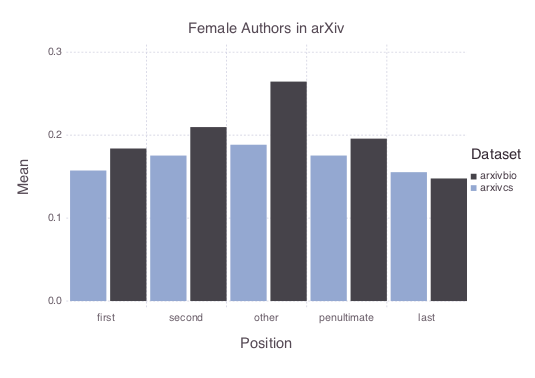

In [39]:
plot(arxivbyposition, x=:Position, y=:Mean, color=:Dataset,
        Scale.color_discrete_manual(my_colors...),
        Guide.title("Female Authors in arXiv"),
        Geom.bar(position = :dodge),
        Scale.x_discrete(levels=["first", "second", "other", "penultimate", "last"]),
        Theme(bar_spacing=2mm))